# Importaciones

In [21]:
#Ejecutar las importaciones más generales
import pandas as pd
import seaborn as sns
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor, LinearRegression

# Carga dataset escalado

In [14]:
# Ruta del archivo escalado
scaled_path = os.path.join(parent_dir, "data", "03_primary", "btcusd_scaled.parquet")

# Verificar existencia
if not os.path.exists(scaled_path):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {scaled_path}")

# Cargar el dataset
btc_scaled = pd.read_parquet(scaled_path)

# Confirmar carga
print(f"✅ Dataset escalado cargado correctamente desde:\n{scaled_path}")
print(f"Dimensiones: {btc_scaled.shape}")
display(btc_scaled.head())

✅ Dataset escalado cargado correctamente desde:
c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\03_primary\btcusd_scaled.parquet
Dimensiones: (4994, 4)


,Low,High,Close,Volume
Timestamp,,,,
2012-01-01,-0.705891,-0.710982,-0.708564,-0.825010
2012-01-02,-0.705881,-0.710977,-0.708558,-0.824999
2012-01-03,-0.705875,-0.710965,-0.708548,-0.814280
2012-01-04,-0.705878,-0.710957,-0.708537,-0.814264
2012-01-05,-0.705854,-0.710925,-0.708507,-0.818342


# Comparación modelo de regresión lineal 

📊 Comparación general entre modelos:



,Modelo,Coeficiente (β₁),R²,p-value (β₁)
0,A: Close ~ Low,0.99967,0.99934,0.0
1,B: Close ~ High,0.99973,0.99947,0.0


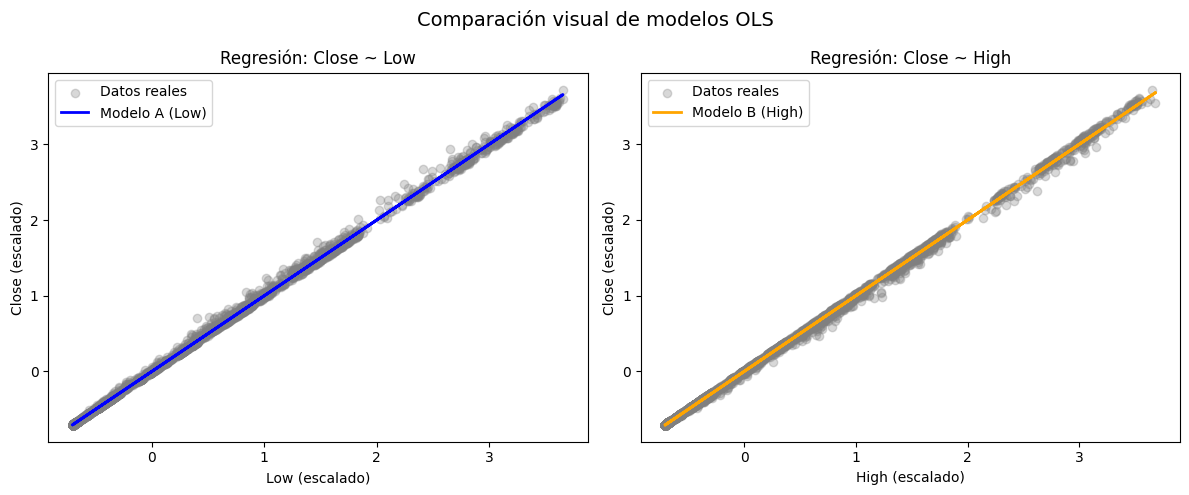

🧠 Según los resultados, el modelo basado en 'High' explica mejor el comportamiento de 'Close'.


In [20]:
# Variable dependiente
y = btc_scaled["Close"]

# --- Modelo A: Close ~ Low ---
X_low = sm.add_constant(btc_scaled["Low"])
model_low = sm.OLS(y, X_low).fit()

# --- Modelo B: Close ~ High ---
X_high = sm.add_constant(btc_scaled["High"])
model_high = sm.OLS(y, X_high).fit()

# --- Comparación resumida ---
comparison = pd.DataFrame({
    "Modelo": ["A: Close ~ Low", "B: Close ~ High"],
    "Coeficiente (β₁)": [model_low.params["Low"], model_high.params["High"]],
    "R²": [model_low.rsquared, model_high.rsquared],
    "p-value (β₁)": [model_low.pvalues["Low"], model_high.pvalues["High"]],
}).round(5)

print("📊 Comparación general entre modelos:\n")
display(comparison)

# --- Gráficos de regresión ---
plt.figure(figsize=(12, 5))

# Gráfico 1: Close ~ Low
plt.subplot(1, 2, 1)
plt.scatter(btc_scaled["Low"], y, color='gray', alpha=0.3, label="Datos reales")
plt.plot(btc_scaled["Low"], model_low.predict(X_low), color='blue', linewidth=2, label="Modelo A (Low)")
plt.title("Regresión: Close ~ Low")
plt.xlabel("Low (escalado)")
plt.ylabel("Close (escalado)")
plt.legend()

# Gráfico 2: Close ~ High
plt.subplot(1, 2, 2)
plt.scatter(btc_scaled["High"], y, color='gray', alpha=0.3, label="Datos reales")
plt.plot(btc_scaled["High"], model_high.predict(X_high), color='orange', linewidth=2, label="Modelo B (High)")
plt.title("Regresión: Close ~ High")
plt.xlabel("High (escalado)")
plt.ylabel("Close (escalado)")
plt.legend()

plt.suptitle("Comparación visual de modelos OLS", fontsize=14)
plt.tight_layout()
plt.show()

# --- Interpretación automática ---
better = "Low" if model_low.rsquared > model_high.rsquared else "High"
print(f"🧠 Según los resultados, el modelo basado en '{better}' explica mejor el comportamiento de 'Close'.")

# Prueba con ransac Modelo resistente a outliers, a ver si cambia en algo los valores.

📊 Resultados del modelo robusto RANSAC:



,Modelo,Coeficiente (β1),R²
0,RANSAC: Close ~ Low,0.99909,0.99934
1,RANSAC: Close ~ High,0.99992,0.99947


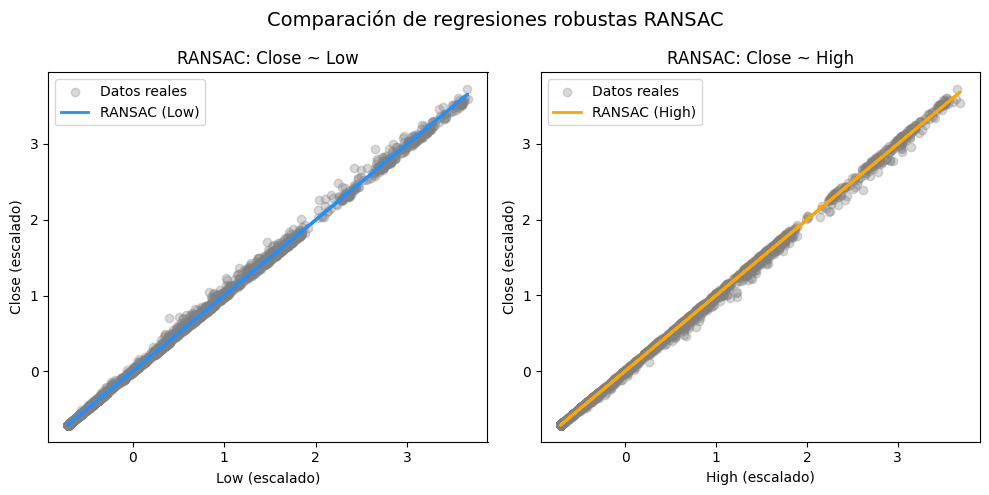

🧠 Según RANSAC, el modelo con 'High' explica mejor la variación de 'Close'.


In [19]:
# Preparar variables
X_low = btc_scaled[["Low"]].values
X_high = btc_scaled[["High"]].values
y = btc_scaled["Close"].values

# --- Modelo A: Close ~ Low ---
ransac_low = RANSACRegressor(estimator=LinearRegression(), random_state=42)
ransac_low.fit(X_low, y)
y_pred_low = ransac_low.predict(X_low)

# --- Modelo B: Close ~ High ---
ransac_high = RANSACRegressor(estimator=LinearRegression(), random_state=42)
ransac_high.fit(X_high, y)
y_pred_high = ransac_high.predict(X_high)

# --- Coeficientes y R² ---
coef_low = ransac_low.estimator_.coef_[0]
coef_high = ransac_high.estimator_.coef_[0]
r2_low = ransac_low.score(X_low, y)
r2_high = ransac_high.score(X_high, y)

# --- Resultados resumen ---
summary_ransac = pd.DataFrame({
    "Modelo": ["RANSAC: Close ~ Low", "RANSAC: Close ~ High"],
    "Coeficiente (β1)": [coef_low, coef_high],
    "R²": [r2_low, r2_high]
})

print("📊 Resultados del modelo robusto RANSAC:\n")
display(summary_ransac.round(5))

# --- Visualización comparativa ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_low, y, color="gray", alpha=0.3, label="Datos reales")
plt.plot(X_low, y_pred_low, color="dodgerblue", linewidth=2, label="RANSAC (Low)")
plt.title("RANSAC: Close ~ Low")
plt.xlabel("Low (escalado)")
plt.ylabel("Close (escalado)")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_high, y, color="gray", alpha=0.3, label="Datos reales")
plt.plot(X_high, y_pred_high, color="orange", linewidth=2, label="RANSAC (High)")
plt.title("RANSAC: Close ~ High")
plt.xlabel("High (escalado)")
plt.ylabel("Close (escalado)")
plt.legend()

plt.suptitle("Comparación de regresiones robustas RANSAC", fontsize=14)
plt.tight_layout()
plt.show()

# Interpretación rápida
better = "Low" if r2_low > r2_high else "High"
print(f"🧠 Según RANSAC, el modelo con '{better}' explica mejor la variación de 'Close'.")